In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres

**I - Data generation and manipulation**

In this practical session we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used for hyperspectral unmixing studies. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 endmembers (i.e. sources).

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

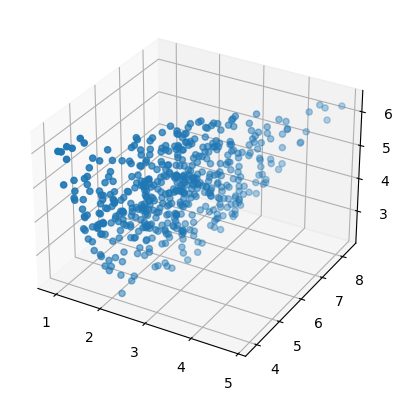

In [2]:
# TO DO : generate A according to the above description.
# TO DO : compute the condition number of A. What would be the issue with an ill-conditioned mixing matrix?
# TO DO : generate S according to the above conditions.
# TO DO : generate X with a linear mixing

n = 3
m = 3
t = 500

A_toy = np.random.random(size=(m,n))*10
S_toy = np.random.random(size=(n,t))
S_toy = S_toy / np.sum(S_toy,axis=0)
X_toy = A_toy@S_toy 


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_toy[0,:],X_toy[1,:],X_toy[2,:])

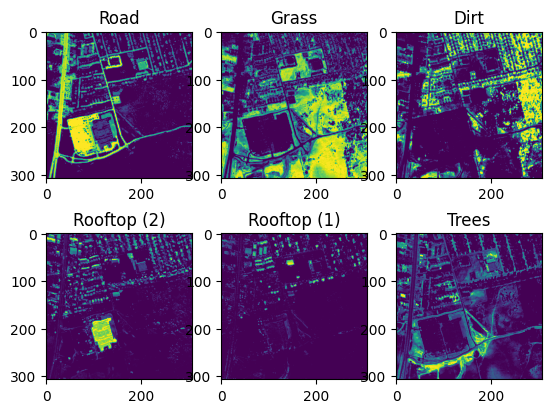

In [26]:
data = sci.loadmat('Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
l = ['Road','Grass','Dirt','Rooftop (2)','Rooftop (1)','Trees']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    ax.set_title(l[ii])
    
    #plt.title(names[ii])

S_gt = abundances
A_gt = gt['M'] 

**2) Real hyperspectral data set** 

First, upload in your working environment the two files Urban.mat and end6_groundTruth.mat, which can be found at https://partage.imt.fr/index.php/s/xezsotfzBndaeX9

Here, we will use the "Urban" dataset:
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (sur groundtruth can for instance be found by on earth geological inquiries). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to the to explain how the following code finds the endmembers. 
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).

__Answers__:

To find out if the data is near separable, we can plot the data in 3D and see if there are points on all the axes. If there are points on all the axes, then the data is not near separable. As we can see, in this case there are not always points on all the axes, so we cannot find, up to a scale factor, the unit vectors of the columns of S. Therefore, the data is not near separable. For it to be separable, we would need to have a pixel with smaller parts, which is not possible with this resolution.

__Answers__:

The code finds the endmembers by using the abundance groundtruth. It first finds the pure pixels for each source using the abundance groundtruth. Then it deduces the columns of X that form almost the matrix A. Finally, it averages over the pure pixels to obtain a single value for each channel knowing that the pixels we have are pure.

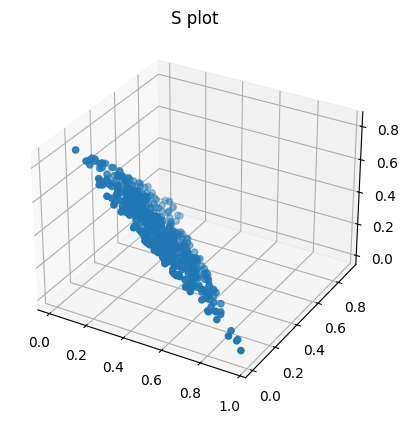

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S_toy[0,:],S_toy[1,:],S_toy[2,:])
ax.set_title("S plot")
plt.show()

(6, 94249) (162, 357)


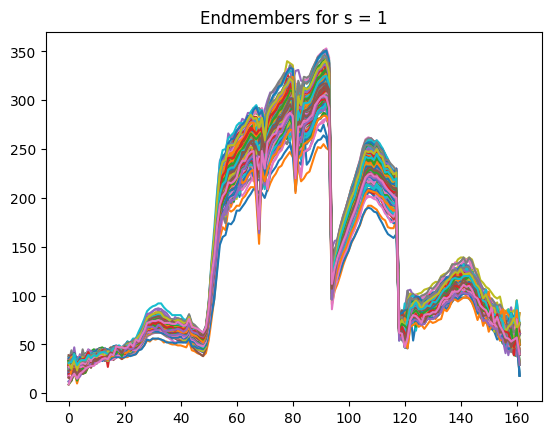

In [5]:
endmembers= np.zeros((162,6))

s = 1

ind = np.where(abundances[s] > 0.999)[0]
allPP = X[:,ind]
print(abundances.shape,allPP.shape)
plt.plot(allPP)
plt.title("Endmembers for s = 1")
plt.show()


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x7ff0c6a52e00>])

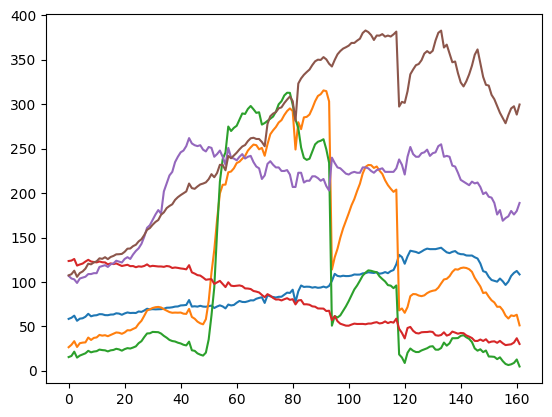

In [6]:
endmembers= np.zeros((162,6))

for ii in range(6): 
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)

**II - Near separable algorithm**

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

The near-separable NMF is when we have $ X = X(:, \mathcal{K})S^* + N$ 

2) Implement the SPA algorithm

In [7]:
def simpleSPA(Xin,r,optDisp=False): # TO DO. 
    
    X = Xin.copy()    
    
    K = np.zeros(r)
    
    for ii in range(r):
        if optDisp  :
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(X[0,:],X[1,:],X[2,:])
            ax.set_title("Residuals with r = %d"%ii)
            plt.show()            

    print('Max residual %s'%np.max(X))

    p = np.argmax(np.linalg.norm(X,axis=0))
    
    K[ii] = p
    
    r_p = X[:,p].reshape(-1,1)
    
    X = (np.identity(X.shape[0]) - r_p@r_p.T / np.linalg.norm(r_p)**2) @ X
        
         
    if optDisp  :
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        ax.scatter(X[0,:],X[1,:],X[2,:])
        ax.set_title("Residuals with r = %d"%r)
        plt.show()    
    
    return K.astype(int)

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA. 

How many sources can you at most extract ? Why ?

__Answers__:
We know that the source is limited by the number of columns of A, which can prevent the determinatino of more sources. In addition, the residuals get smaller as the data is projected into the SPA, which makes them more likely to be inaccurate, which also affects the determination of the sources.

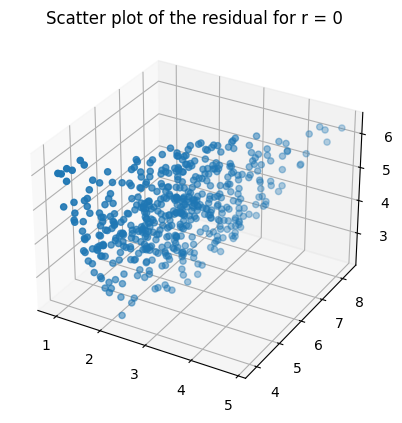

Max residual 8.337776808739775


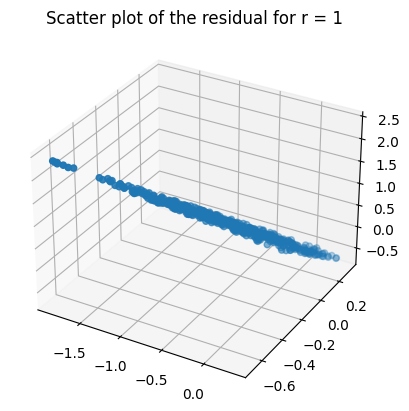

Max residual 2.372897787429976


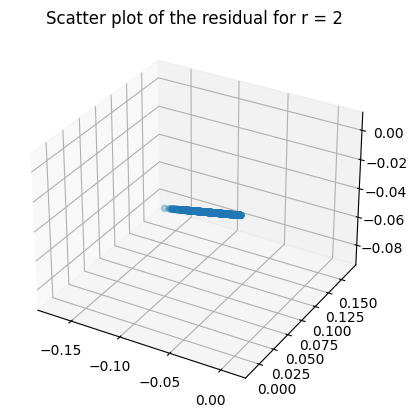

Max residual 0.1655429635058935


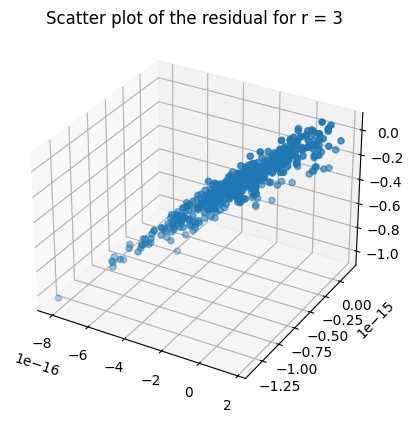

Max residual 1.686072226781894e-16


In [13]:
K_SPA = simpleSPA(X_toy,3,optDisp = True)

**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms. 

Use the evalCriterion function to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

__Answers__:

We can see that the result is relatively good, since it is quite similar to the true endmembers, but there are still some differences that make the determination of S_est less reliable.

In [14]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));
    
    return An



        
def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W0 = norm_col(W0)
    W = norm_col(W)
    
    costmat = -W0.T@W; # Avec Munkres, il faut bien un -

    
    m = Munkres()
    Jperm = m.compute(costmat.tolist())
    
    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])
    
    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]
        
    return WPerm,indPerm.astype(int)




def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W,indPerm = correctPerm(W0,W);
    
    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;
    
    return np.mean(np.diag(diff));

Max residual 1000.0
Max residual 603.4173437070264
Max residual 503.62039752697126
Max residual 202.6288289887583
Max residual 180.78413293311726
Max residual 160.9937233096636
Eval criterion 0.9149174369799747


Text(0.5, 1.0, 'Label endmembers')

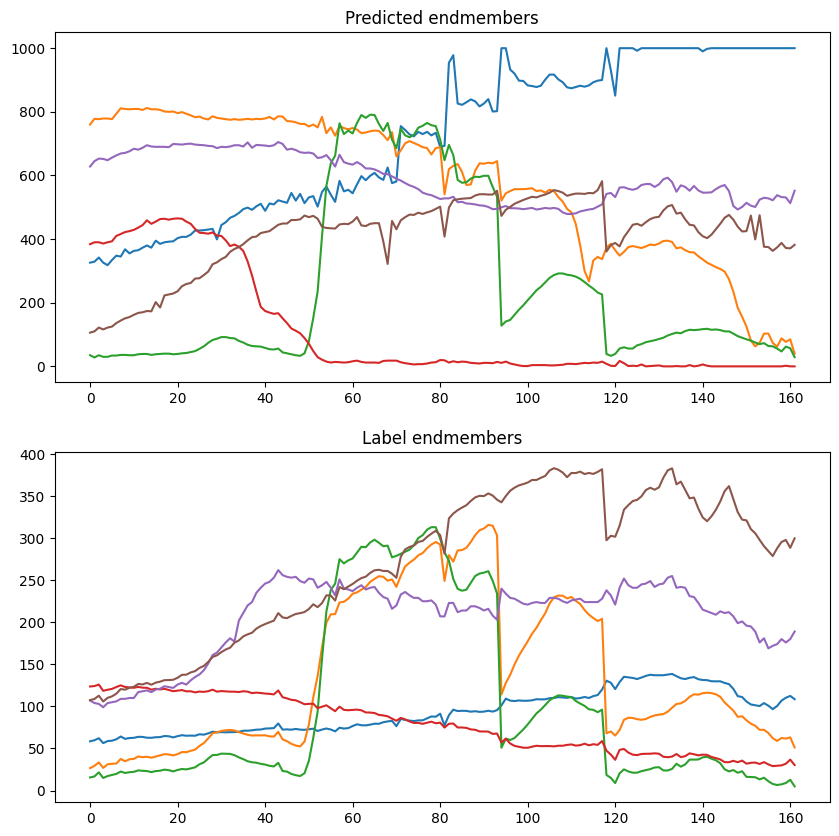

In [20]:
K_spa = simpleSPA(X,6,optDisp = False)
A = X[:,K_spa]
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
print("Eval criterion",evalCriterion(endmembers,A))
ax[0].plot(A)
ax[0].set_title("Predicted endmembers")


ax[1].plot(endmembers)
ax[1].set_title("Label endmembers")

**5)** (Bonus) The SPA algorithm gives you an estimation of the mixing matrix. Code an ISTA algorithm to obtain the corresponding sources (abundances). Plot them.

**III - PLAIN NMF**

In this part we use the PALM algorithm to perform plain NMF. Of course, if you already coded the PALM algorihtm with sparsity constriant in the previous TP, you can just adapt it.

This optimization scheme is simple but can provide decent separation results.

**1)** Write the cost function of plain NMF.

__Answers__:
We can define the cost function of plain NMF as follows:

$$
\frac{1}{2}||X-AS||^2 + \lambda ||S||_1 + \mathbb{1}A
$$

**2)** Implement the proximal operator of the nonnegativity constraint.

In [21]:
def prox_positive(S): # TO DO
    S[S<0] = 0
    return S

**3)** Implement the PALM algorithm to solve the plain NMF problem.

In [22]:
def PALM(X, n=2, nbIt=100, Ainit=None, Sinit=None):
    if Ainit is None:
        A_est = np.random.rand(X.shape[0], n)
    else:
        A_est = Ainit
    
    if Sinit is None:
        S_est = np.random.rand(n, X.shape[1])
    else:
        S_est = Sinit
    
    k = 0
    
    while k < nbIt:
        if k % 25 == 0:
            print(k, end=', ')
        
        gamma = 0.9 / np.linalg.norm(A_est @ (A_est.T))
        eta = 0.9 / np.linalg.norm(S_est @ (S_est.T))
        
        S_est = prox_positive(S_est + gamma * np.matmul(A_est.T, (X - np.matmul(A_est, S_est))))
        A_est = prox_positive(A_est + eta * np.matmul((X - np.matmul(A_est, S_est)), S_est.T))
        
        k += 1
    
    return A_est, S_est

**4)** 
Launch the PALM algorithm on the real hyperspectral dataset. 

Can you find of a better initialization than the random one ?

Compare your result, both qualitatively and quantitatively, with the SPA algorithm. Explain the differences.

Plot the abundances.

__Answers__:

It is possible to use the results obtained with the SPA and the optional ISTA in order as the initialization. We can see that just some of the sources output a good result, while many of them are worse.

In [23]:
# CORRECTION
A_in = X[:,K_spa]
A_est,S_est = PALM(X,n=6,nbIt = 1000,Ainit=A_in,Sinit=None) # TO DO: modify the initialization

0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 

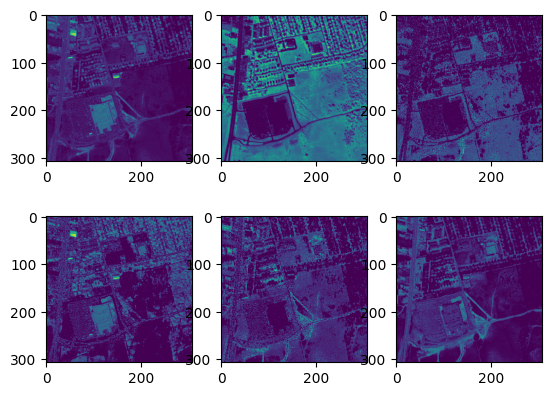

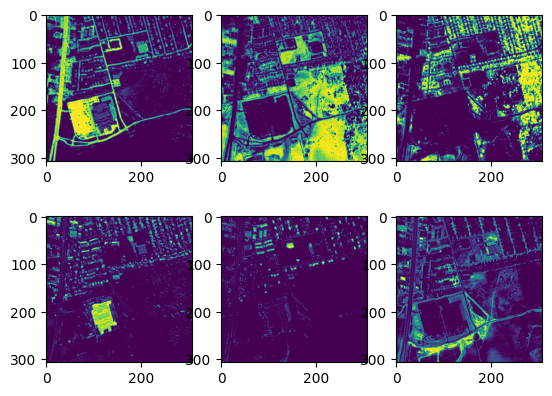

In [37]:
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_est[ii,:].reshape(nCol,nRow))

plt.show()   
    
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_gt[ii,:].reshape(nCol,nRow))
    
plt.show()

Evaluation criterion 0.8910832325901127


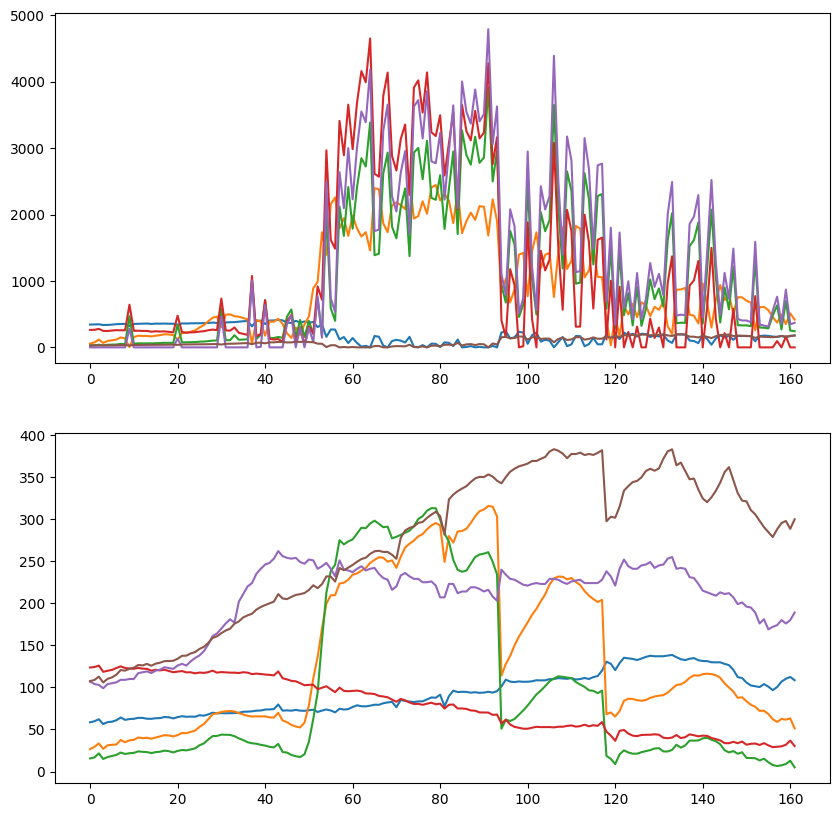

In [51]:
print("Evaluation criterion",evalCriterion(endmembers,A_est))

fig,ax = plt.subplots(2,1, figsize=(10,10))

ax[0].plot(A_est)
ax[1].plot(endmembers)
plt.show()


**IV - MINIMUM VOLUME NMF**

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classes, the code is fully given below.

In [52]:
def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex  

#       Delta = { x | x >= 0 and sum(x) <= 1 }, 

# that is, Y = argmin_z ||x-X||_2  such that z in S. 

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ****** 
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ****** 
# Y       : the projected matrix

    
    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1]) 
    
    Y = np.zeros(np.shape(X))
    
    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy
    
        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;
        
        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection
    
        min_sum=np.sum(x)-len(x)*mu_min
        
        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/np.float(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1
                
                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)
                
                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind
                    
                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True
                    
                    
                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True
                    
                    
            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))
                
            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear
            
            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)
            
            Y[:,ii]=y
            
            
            
    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.  
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
    # Course, Kluwer Academic Publisher, 2004. 
    
    # This code solves: 
    
    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter) 
    
    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500). 
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above. 
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A))); 
    
    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)
        
    
    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6
    
    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W
        
        # FGM Coefficients  
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2); 
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1)); 
        
        # Projected gradient step from Y
        W = Y - (Y@A-C) / L 
        
        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )
            
        
        # Linear combination of iterates
        Y = W + beta*(W-Wp)
        
        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)
        
        
        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out. 
        
        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W
            
        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))
        
        eps = np.sqrt(np.sum((W-Wp)**2))
        
        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)
    
     #           min_{H >= 0} ||X-WH||_F^2
     
     # using a fast gradient method; 
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
     # Course, Kluwer Academic Publisher, 2004. 
     
     # Input / Output; see nnls_input_output.m  
     
     # + options.proj allows to use a contraints on the columns or rows of H so 
     #   that the entries in each column/row sum to at most one 
     #   options.proj = 0: no projection (default). 
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1} 
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1} 
          
     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM
    

   
    
    # If no initial matrices are provided, H is initialized as follows: 
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))

    
    # Hessian and Lipschitz constant 
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term 
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0
    
    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0) 
        K = np.where(np.sum(H,axis=0) > 1.)[0] 
        H[:,K] = simplexProx( H[:,K] ) 
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T 
    
    
    
    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1  
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H; 
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L
        
        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1} 
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )  
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T
        
        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')
        
        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1; 
      


    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X): 
    # Normalization depending on the NMF model 
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1
                      
        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g. 
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T
        
        H = Hn 
        
    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )
        
    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2
    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)
    
    WtW = W.T@W;
    WtX = W.T@X;
    
    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)
    
    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK
    
    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))
    
    e[0] =  err1[0] + lamb * err2[0] # OK

    
    
    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0
    
    
    # Main loop 
    
    for ii in range(1,maxiter):
        print(ii)
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T
        
        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt
        
        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H
        
        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)
        
        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))
        
        e[ii] = err1[ii] + lamb * err2[ii]
        
        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05
                
                
    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [57]:
[W3_t,H3_t,e3_t,er13_t,er23_t] = minvolNMF(X,W=A_est,H=S_est,r=6,lamb=1.,maxiter=1000,target=0.05,model=1)

/tmp/ipykernel_30869/951971004.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mu=(np.sum(x)-1.)/np.float(len(x))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.

__Answers__:

We can see that the last algorithm had a better performance than the simpler one. It is expected in some ways, since it is able to better model thw problem due to its complexity.

Eval criterion for A 0.9358122273708435


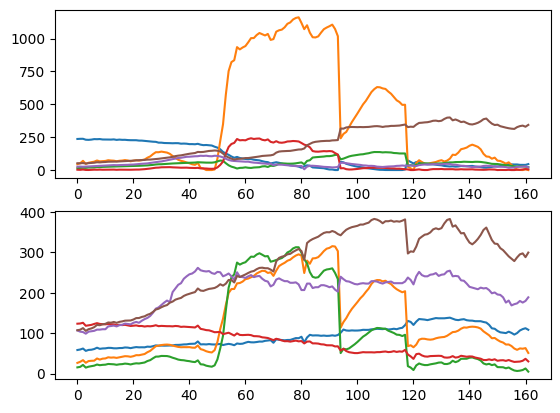

In [58]:
print('Eval criterion for A',evalCriterion(endmembers,W3_t))

fig,ax = plt.subplots(2,1)

ax[0].plot(W3_t)
ax[1].plot(endmembers)
plt.show()

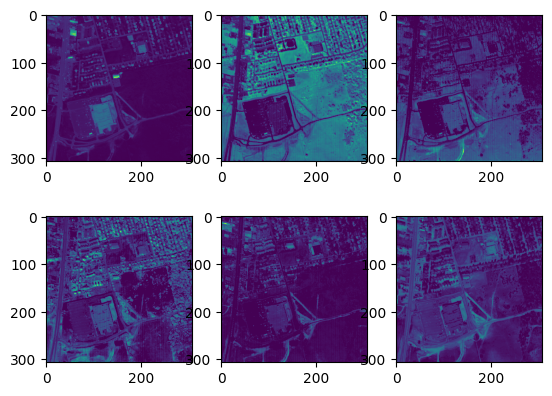

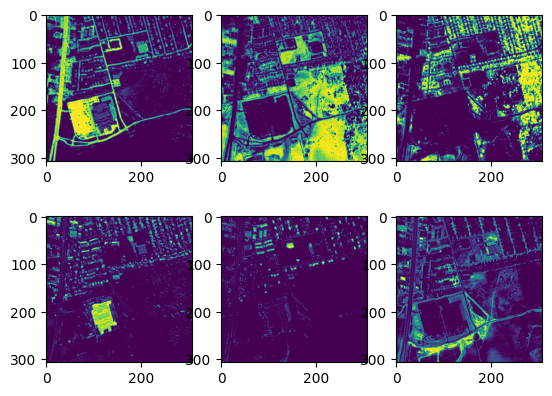

In [60]:
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(H3_t[ii,:].reshape(nCol,nRow))

plt.show()   
    
plt.figure()
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_gt[ii,:].reshape(nCol,nRow))
    
plt.show()